<h1 style="color: blue; font-size: 25px;">Import Necessary Libraries</h1>

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import pickle

import warnings
warnings.filterwarnings("ignore")

In [22]:
df = pd.read_csv('email_data.csv')
df

,email,label
0,Upgrade to our premium plan for exclusive acce...,ham
1,Happy holidays from our team! Wishing you joy ...,ham
2,We're hiring! Check out our career opportuniti...,ham
3,Your Amazon account has been locked. Click her...,spam
4,Your opinion matters! Take our survey and help...,ham
...,...,...
174,We're pleased to inform you that your refund h...,ham
175,Get rich quick! Invest in our revolutionary ne...,spam
176,Your free trial period is ending soon. Upgrade...,ham
177,Your order is on its way! Track your shipment ...,ham


In [23]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()
label_counts

label
ham     100
spam     79
Name: count, dtype: int64

<h1 style="color: blue; font-size: 25px;">Visualization</h1>

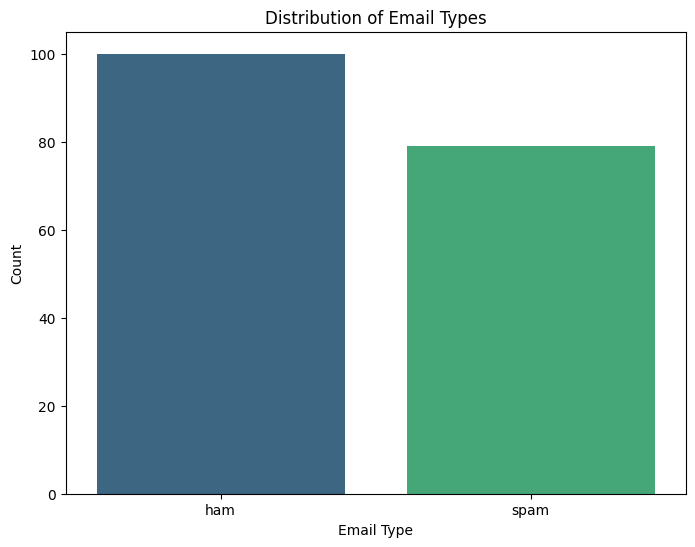

In [24]:
# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')

# Add titles and labels
plt.title('Distribution of Email Types')
plt.xlabel('Email Type')
plt.ylabel('Count')

# Show the plot
plt.show()

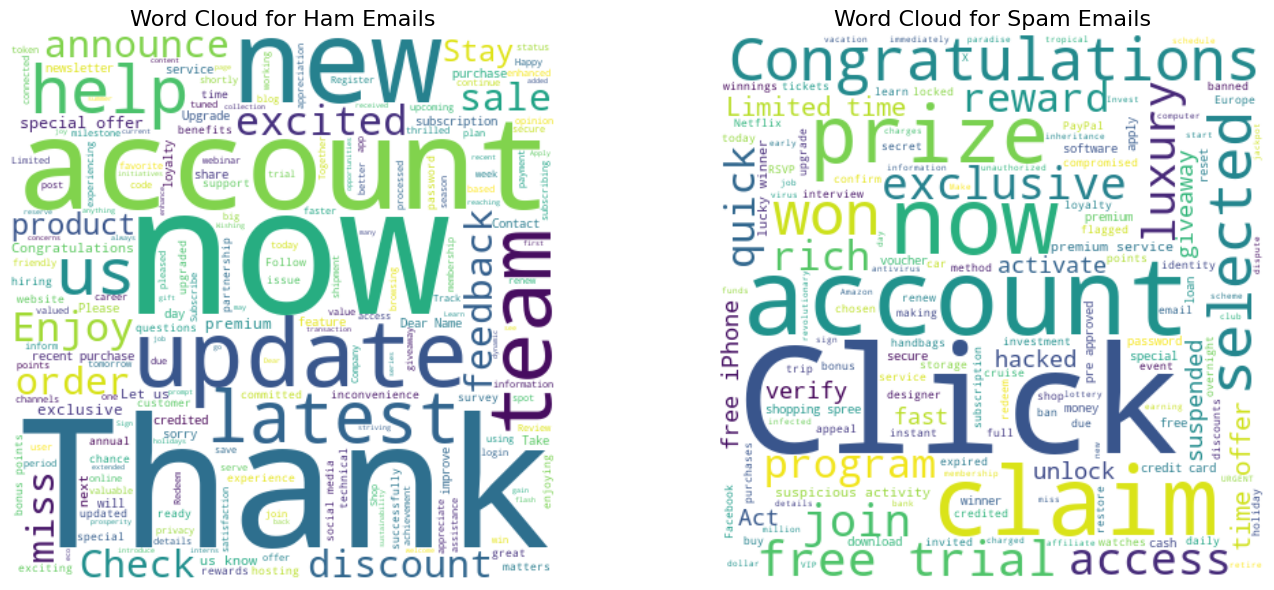

In [25]:
from wordcloud import WordCloud
ham_text_data = df[df['label'] == 'ham']['email'].values
spam_text_data = df[df['label'] == 'spam']['email'].values

all_ham_text = ' '.join(ham_text_data)
all_spam_text = ' '.join(spam_text_data)

wordcloud_ham = WordCloud(width = 400, height = 400, background_color = 'white').generate(all_ham_text)
wordcloud_spam = WordCloud(width = 400, height = 400, background_color = 'white').generate(all_spam_text)

plt.figure(figsize=(15, 6))

# ham emails
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_ham, interpolation = 'bilinear')
plt.title('Word Cloud for Ham Emails', fontsize = 16)
plt.axis('off')

# spam emails
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_spam, interpolation = 'bilinear')
plt.title('Word Cloud for Spam Emails', fontsize = 16)
plt.axis('off')

plt.tight_layout()
plt.show()

<h1 style="color: blue; font-size: 25px;">Data Preprocessing</h1>

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

# initialize labelEncoder & countVectorizer
encoder = LabelEncoder()
vectorizer = CountVectorizer()

# clean all the emails
df['email'] = df['email'].apply(preprocess_text)

# encode the labels
df['label'] = encoder.fit_transform(df['label'])

# display the modified dataset
df.head()


,email,label
0,upgrade to our premium plan for exclusive acce...,0
1,happy holidays from our team wishing you joy a...,0
2,were hiring check out our career opportunities...,0
3,your amazon account has been locked click here...,1
4,your opinion matters take our survey and help ...,0


In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Preprocessing
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['email'])
sequences = tokenizer.texts_to_sequences(df['email'])

<h1 style="color: blue; font-size: 25px;">Developing the Classification Model </h1>

In [28]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Assuming you have data and labels
X = pad_sequences(sequences, maxlen=max_len)
y = df['label'].values

# One-hot encode the labels
y = to_categorical(y, num_classes=2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Print the shape of train/test features and labels
print(f'\nShape of Training Features (X_train) --> {X_train.shape} and \
Training Labels (y_train) --> {y_train.shape}')
print(f'\nShape of Testing Features (X_test) --> {X_test.shape} and \
Testing Labels (y_test) --> {y_test.shape}')


Shape of Training Features (X_train) --> (143, 100) and Training Labels (y_train) --> (143, 2)

Shape of Testing Features (X_test) --> (36, 100) and Testing Labels (y_test) --> (36, 2)


<h1 style="color: blue; font-size: 20px;">LSTM Model </h1>

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Building the RNN model with LSTM layers
model = Sequential()

# Embedding layer to learn word representations
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))

# First LSTM layer with Dropout
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer with Dropout
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2, activation='softmax')) 

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=['Not Spam', 'Spam']))

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.4394 - loss: 0.6959 - val_accuracy: 0.5517 - val_loss: 0.6691
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6786 - loss: 0.6690 - val_accuracy: 0.9655 - val_loss: 0.6324
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9913 - loss: 0.6087 - val_accuracy: 0.9655 - val_loss: 0.5098
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9763 - loss: 0.4407 - val_accuracy: 0.9655 - val_loss: 0.2956
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8644 - loss: 0.3114 - val_accuracy: 1.0000 - val_loss: 0.1291
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9794 - loss: 0.1266 - val_accuracy: 1.0000 - val_loss: 0.0827
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0642 - val_accuracy: 1.0000 - val_loss: 0.0357
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0351 - val_accuracy: 1.0000 - val_loss: 0.0124

In [30]:
# Save Model
model.save(r'C:\Users\Abinesh.R\Documents\Email Classification\email_classifier.h5')
with open(r'C:\Users\Abinesh.R\Documents\Email Classification\tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

    Not Spam       0.96      0.92      0.94        25
        Spam       0.83      0.91      0.87        11

    accuracy                           0.92        36
   macro avg       0.90      0.91      0.90        36
weighted avg       0.92      0.92      0.92        36



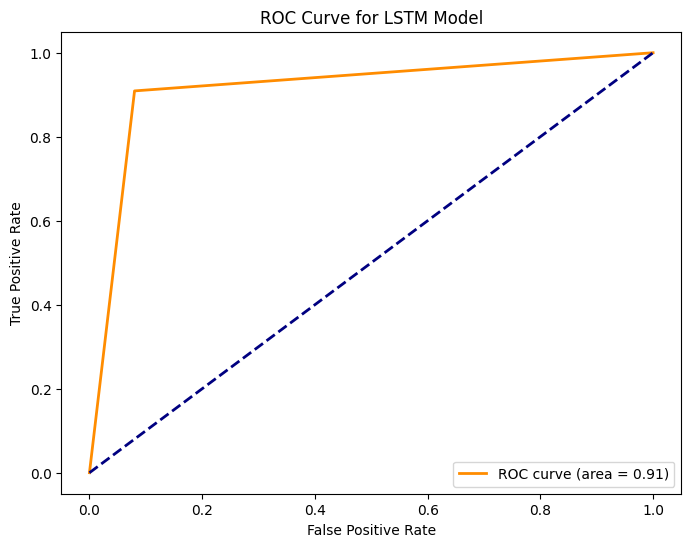

In [31]:
# Model Evaluation
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=['Not Spam', 'Spam']))

# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred_classes)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM Model')
plt.legend(loc='lower right')
plt.show()